## 0. Setup

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
# Set up random seed to 1008. Do not change the random seed.
seed = 1008
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

## 1. Data: MNIST
#### Load the MNIST training and test dataset using $\texttt{torch.utils.data.DataLoader}$ and $\texttt{torchvision.datasets}$. 

Hint: You might find Alf's notebook useful: https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/06-convnet.ipynb

### 1.1. Load Training Set [4 pts]

In [4]:
# Load the MNIST training set with batch size 128, apply data shuffling and normalization
batch_size=128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

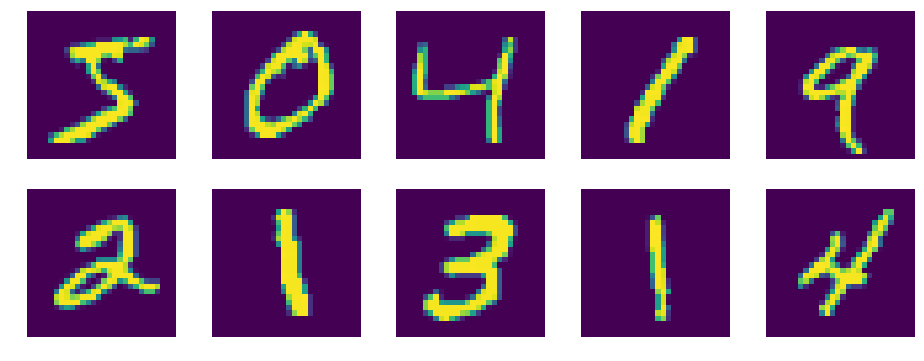

In [5]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### 1.1. Load Test Set [4 pts]

In [6]:
# Load the MNIST test set with batch size 128, apply data shuffling and normalization
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

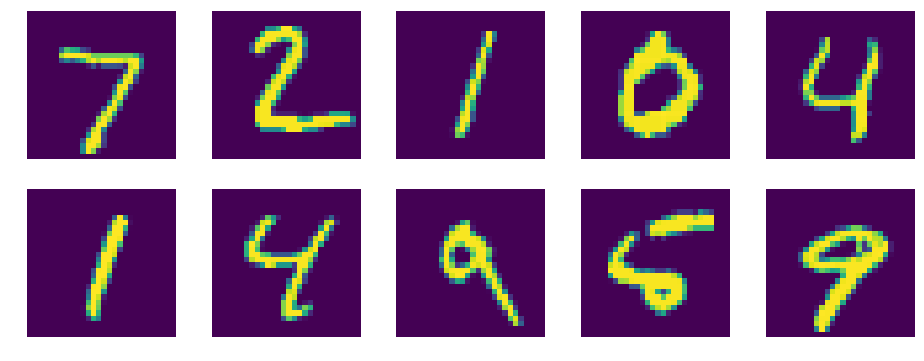

In [7]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

## 2. Models
#### You are going to define two convolutional neural networks which are trained to classify MNIST digits

### 2.1. CNN without Batch Norm [15 pts]

In [8]:
# Fill in the values below that make this network valid for MNIST data

# conv1_in_ch = TODO
# conv2_in_ch = TODO
# fc1_in_features = TODO
# fc2_in_features = TODO
# n_classes = TODO

conv1_in_ch = 1
conv2_in_ch = 20
fc1_in_features = 800
fc2_in_features = 500
n_classes = 10

In [9]:
class NetWithoutBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv1_in_ch, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_ch, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=500)
        self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, fc1_in_features) # reshaping
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 2.2. CNN with Batch Norm [15 pts]

In [10]:
# Fill in the values below that make this network valid for MNIST data

# conv1_bn_size = TODO
# conv2_bn_size = TODO
# fc1_bn_size = TODO

conv1_bn_size = 20
conv2_bn_size = 50
fc1_bn_size = 500

In [11]:
# Define the CNN with architecture explained in Part 2.2
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv1_in_ch, out_channels=20, kernel_size=5, stride=1)
        self.conv1_bn = nn.BatchNorm2d(conv1_bn_size)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_ch, out_channels=50, kernel_size=5, stride=1)
        self.conv2_bn = nn.BatchNorm2d(conv2_bn_size)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=500)
        self.fc1_bn = nn.BatchNorm1d(fc1_bn_size)
        self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=n_classes)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, fc1_in_features)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## 3. Training & Evaluation

### 3.1. Define training method [15 pts]

In [13]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 100):
    # Set model to training mode
    model.train()
    # Loop through data points
    for batch_idx, (data, target) in enumerate(train_loader):
    
        # Send data and target to device
        data, target = data.to(device), target.to(device)

        # Zero out the optimizer
        optimizer.zero_grad()
        
        # Pass data through model
        output = model(data)

        # Compute the negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # Backpropagate loss
        loss.backward(retain_graph=True)
        
        # Make a step with the optimizer
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### 3.2. Define test method [15 pts]

In [ ]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    with torch.no_grad():
        
        # Loop through data points
        for data, target in test_loader:
        
            # Send data to device
            data, target = data.to(device), target.to(device)
        
            # Pass data through model
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            
            # Get predictions from the model for each data point
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            
            # Add number of correct predictions to total num_correct 
            num_correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    # Compute the average test_loss
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))

### 3.3 Train NetWithoutBatchNorm() [5 pts]

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
# Define model and sent to device
model = NetWithoutBatchNorm()
model.to(device)

# Optimizer: SGD with learning rate of 1e-2 and momentum of 0.5
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

#print('Number of parameters: {}'.format(get_n_params(model)))

# Training loop with 10 epochs
for epoch in range(1, 10 + 1):
    # Train model
    train(model, device, train_loader, optimizer, epoch, log_interval = 100)
    
    # Test model
    test(model, device, test_loader)

### 3.4 Train NetWithBatchNorm() [5 pts]

In [ ]:
# Deifne model and sent to device
model = NetWithBatchNorm()
model.to(device)

# Optimizer: SGD with learning rate of 1e-2 and momentum of 0.5
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Training loop with 10 epochs
for epoch in range(1, 10 + 1):

    # Train model
    train(model, device, train_loader, optimizer, epoch, log_interval = 100)
    
    # Test model
    test(model, device, test_loader)

## 4. Empirically, which of the models achieves higher accuracy faster? [2 pts]

Answer: Training with batch normalization achieves higher accuracy faster. The batch normalization version of same cnn reaches 99% of accuracy after less number of epochs compared to the same cnn without batch normalization.
Batch normalization reduces the dependencies between layers, and stabilizes the neural network. 
Some of the benefits are:
1. Batch normalization allows each layer of a network to learn by itself more independently of other layers (covariance shift).

2. People can use higher learning rates because batch normalization makes sure that’s there is not activation that’s gone too high or too low. The network trains faster.

3. It reduces overfitting because it has a slight regularization effect. Similar to dropout it adds some noise to each hidden layer’s activation.

